# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [5]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [6]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [7]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_1
Gradients are different at (538, 1). Analytic: 0.00000, Numeric: 0.00001


False

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [8]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_1
Gradient check passed!
Checking gradient for B_1
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [9]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [21]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.236578, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.200731, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.373339, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.243615, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.199005, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.224350, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.189453, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.079634, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315894, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.888670, Train accuracy: 0.203333, val accuracy: 0.208000
Loss: 2.087026, Train accuracy: 0.217889, val accuracy: 0.223000
Loss: 1.923451, Train accuracy: 0.234556, val accuracy: 0.234000
Loss: 2.209656, Train accuracy: 0.250556, val accuracy: 0.250000
Loss: 2.248846, Train accuracy: 0.264778, val accuracy: 0.262000
Loss: 2.141485, Train accuracy: 0.262556, val accuracy: 0.261000
Loss: 2.171981, Train acc

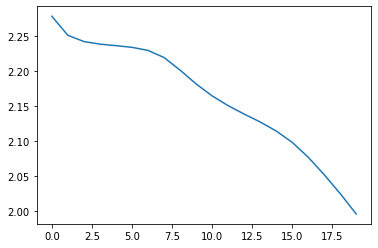

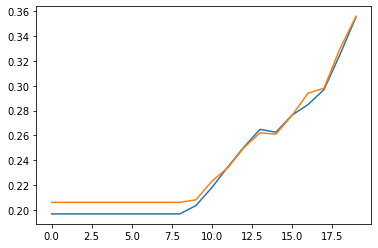

In [22]:
plt.plot(loss_history)
plt.show()

plt.plot(train_history)
plt.plot(val_history)
plt.show()

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [35]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99, learning_rate = 1e-2)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.304383, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265730, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.187751, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298083, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.201331, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.181506, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297584, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.203270, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.138639, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.883369, Train accuracy: 0.197778, val accuracy: 0.205000
Loss: 1.928133, Train accuracy: 0.213111, val accuracy: 0.217000
Loss: 2.084763, Train accuracy: 0.228222, val accuracy: 0.235000
Loss: 2.164852, Train accuracy: 0.245000, val accuracy: 0.248000
Loss: 2.290525, Train accuracy: 0.254778, val accuracy: 0.251000
Loss: 2.097281, Train accuracy: 0.264778, val accuracy: 0.261000
Loss: 2.165448, Train acc

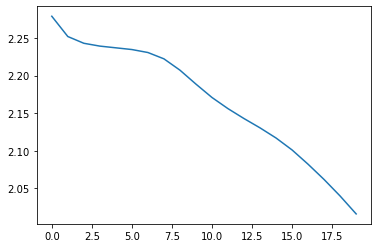

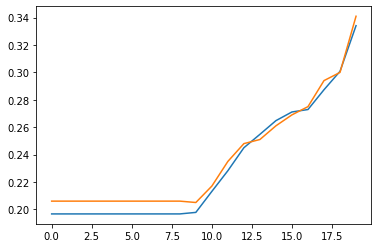

In [36]:
plt.plot(loss_history)
plt.show()

plt.plot(train_history)
plt.plot(val_history)
plt.show()

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [37]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.174623, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.382159, Train accuracy: 0.317111, val accuracy: 0.313000
Loss: 1.785812, Train accuracy: 0.419000, val accuracy: 0.420000
Loss: 1.937279, Train accuracy: 0.486333, val accuracy: 0.470000
Loss: 1.916761, Train accuracy: 0.523444, val accuracy: 0.520000
Loss: 1.747250, Train accuracy: 0.528444, val accuracy: 0.552000
Loss: 1.887827, Train accuracy: 0.581333, val accuracy: 0.579000
Loss: 1.675332, Train accuracy: 0.552111, val accuracy: 0.552000
Loss: 1.743425, Train accuracy: 0.583556, val accuracy: 0.576000
Loss: 1.384647, Train accuracy: 0.594889, val accuracy: 0.599000
Loss: 1.887524, Train accuracy: 0.598111, val accuracy: 0.605000
Loss: 1.693649, Train accuracy: 0.570444, val accuracy: 0.578000
Loss: 2.186511, Train accuracy: 0.585667, val accuracy: 0.580000
Loss: 1.680001, Train accuracy: 0.614889, val accuracy: 0.598000
Loss: 2.047940, Train accuracy: 0.610444, val accuracy: 0.603000
Loss: 1.857347, Train acc

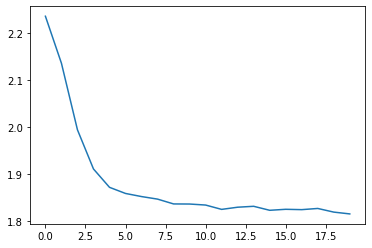

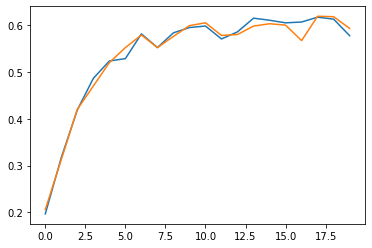

In [38]:
plt.plot(loss_history)
plt.show()

plt.plot(train_history)
plt.plot(val_history)
plt.show()

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [45]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.306361, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296428, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.268830, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.287500, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.238646, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.257516, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.202832, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.176420, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.179951, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.290675, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.082170, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.289752, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.530483, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.633904, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.114697, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.195749, Train acc

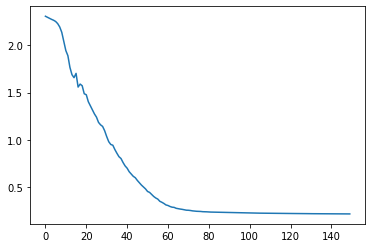

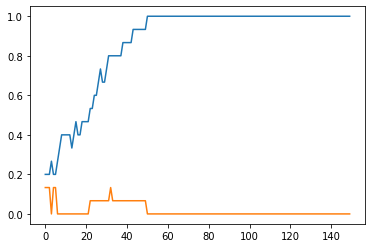

In [46]:
plt.plot(loss_history)
plt.show()

plt.plot(train_history)
plt.plot(val_history)
plt.show()

`Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [118]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 200, reg = 1e-4)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1.3e-1, num_epochs=20, batch_size=2)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.327392, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.196088, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.077443, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 2.332148, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 1.271869, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 1.755637, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.472866, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.381446, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 0.001029, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 2.979343, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 1.531141, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 1.440467, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 2.235392, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.194271, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.003424, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.012251, Train acc

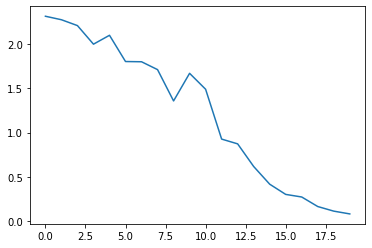

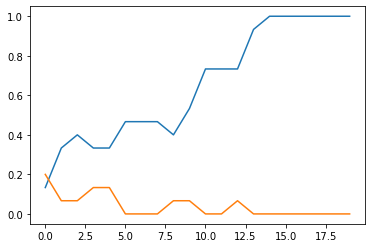

In [119]:
plt.plot(loss_history)
plt.show()

plt.plot(train_history)
plt.plot(val_history)
plt.show()

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [124]:
# Let's train the best one-hidden-layer network we can

learning_rate = 1e-2
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

dataset = Dataset(train_X, train_y, val_X, val_y)

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10,
                     hidden_layer_size = hidden_layer_size, reg = reg_strength)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate,
                     num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay=learning_rate_decay)

loss_history, train_history, val_history = trainer.fit()

best_val_accuracy = max(val_history)
best_classifier = model

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.287844, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.211101, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.171281, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.035652, Train accuracy: 0.262889, val accuracy: 0.260000
Loss: 1.891446, Train accuracy: 0.308111, val accuracy: 0.309000
Loss: 1.801684, Train accuracy: 0.410778, val accuracy: 0.406000
Loss: 1.884686, Train accuracy: 0.466000, val accuracy: 0.466000
Loss: 1.583442, Train accuracy: 0.529778, val accuracy: 0.524000
Loss: 1.261934, Train accuracy: 0.590222, val accuracy: 0.571000
Loss: 1.594232, Train accuracy: 0.613889, val accuracy: 0.592000
Loss: 1.399512, Train accuracy: 0.649000, val accuracy: 0.634000
Loss: 1.218371, Train accuracy: 0.672333, val accuracy: 0.665000
Loss: 1.263789, Train accuracy: 0.692667, val accuracy: 0.686000
Loss: 0.951730, Train accuracy: 0.704889, val accuracy: 0.678000
Loss: 1.069061, Train accuracy: 0.705556, val accuracy: 0.693000
Loss: 0.762312, Train acc

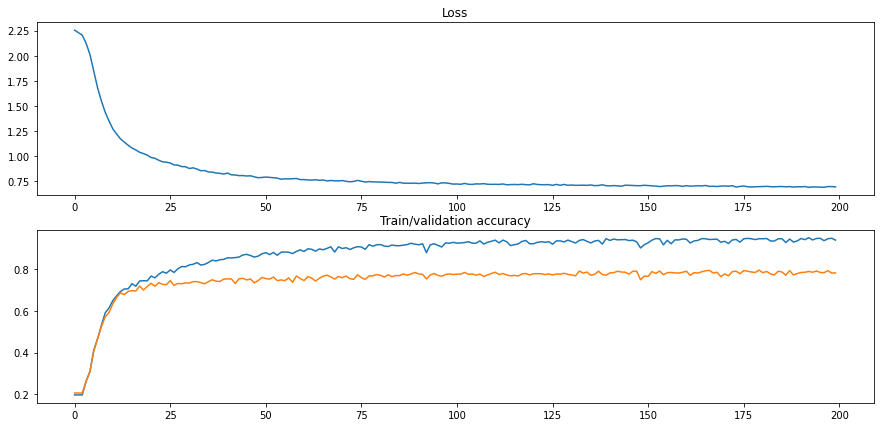

In [125]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [126]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.765000
